In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Set up the input pipeline

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-c7exzaim
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-c7exzaim
  Resolved https://github.com/tensorflow/examples.git to commit 9084c2efc4837ecaa2544b43ea2f3c26b593dde4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1727910282.825055350737006839036646584288485110499677298148-py3-none-any.whl size=301602 sha256=79928f4e5d27a469fd2166107bee0127a4aa3362dcf4a4f59a721d2de965df82
  Stored in directory: /tmp/pip-ephem-wheel-cache-u60h_pwc/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones here.

As mentioned in the paper, apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in pix2pix

In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256.
In random mirroring, the image is randomly flipped horizontally i.e., left to right.

In [4]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.3T4S4M_3.0.0/cycle_gan-trainA.tfrecord*..…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.3T4S4M_3.0.0/cycle_gan-trainB.tfrecord*..…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.3T4S4M_3.0.0/cycle_gan-testA.tfrecord*...…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.3T4S4M_3.0.0/cycle_gan-testB.tfrecord*...…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


In [7]:
print(dataset,'\n',type(dataset))

{'trainA': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'trainB': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'testA': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'testB': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>} 
 <class 'dict'>


In [8]:
# Used to split the dataset as zebras and horses training and validation sets.

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [10]:
type(train_horses)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [11]:
# preset values, we try to increase the size to (286,286) and then crop it randomly to (256,256) 
# as done previously in the pix2pix paper

BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [14]:
# function to crop the image to desired size, kyuki bhai zaruri hain :D 

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [16]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [17]:
# function to do the resizing and cropping into desired size

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [18]:
# function to preprocess the training images 
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

# function to preprocess the test images (we do not apply random jitter and cropping)
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [21]:
# shuffling the images and creating batches of images which can be read and printed out, because as seen earlier,
# the images could nto be orinted.

train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [30]:
# loading a sample horse and zebra from the dataset
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

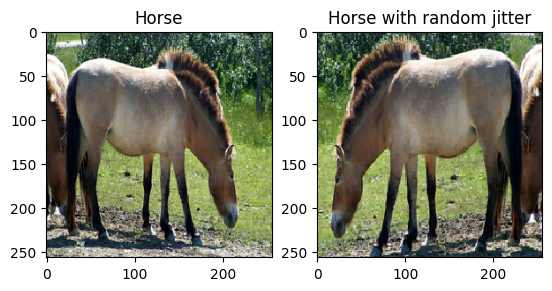

In [27]:
# Plotting a random horse taken from the dataset next to the same horse but with random jitter function applied to it.

plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

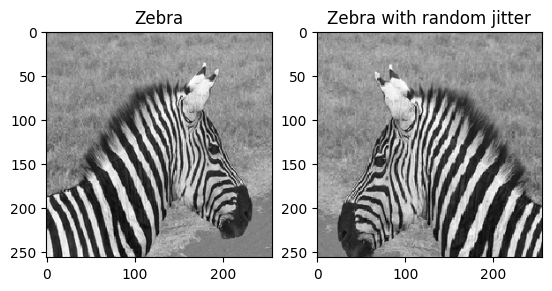

In [31]:
# Plotting a random hzebra taken from the dataset next to the same zebra but with random jitter function applied to it.

plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models
Import the generator and the discriminator used in Pix2Pix via the installed tensorflow_examples package.

The model architecture used in this tutorial is very similar to what was used in pix2pix. Some of the differences are:

Cyclegan uses instance normalization instead of batch normalization.
The CycleGAN paper uses a modified resnet based generator. This tutorial is using a modified unet generator for simplicity.
There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here.

Generator G learns to transform image X to image Y.<br> 
Generator F learns to transform image Y to image X.<br>
Discriminator D_X learns to differentiate between image X and generated image X (F(Y)).<br>
Discriminator D_Y learns to differentiate between image Y and generated image Y (G(X)).<br>

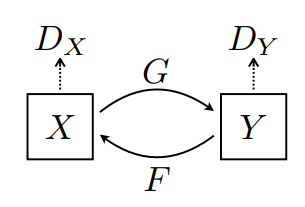<br>
Cyclegan model.

In [32]:
# lodaing the pretrained pix2pix models and there are 2 generators and 2 discriminators, hence the 'Cycle'
# in CycleGAN.

OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Generator_g is for generating horses

Generator_f is for generating zebras

discriminator_x is for discriminating horse images

discriminator_y is for discriminating zebra images

In [59]:
generator_g.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, None,      │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, None,      │    131,328 │ sequential[0][0]  │
│ (Sequential)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, None,      │    524,800 │ sequential_1[0][… │
│ (Sequential)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, None,      │  2,098,176 │ sequential_2[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, None,      │  4,195,328 │ sequential_3[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, None,      │  4,195,328 │ sequential_4[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, None,      │  4,195,328 │ sequential_5[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, None,      │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, None,      │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ None, 128)        │            │ sequential_6[0][… │
│                     │                   │            │ sequential_9[0][… │
│                     │                   │            │ sequential_5[0][… │
│                     │                   │            │ sequential_10[0]… │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ sequential_11[0]… │
│                     │                   │            │ sequential_3[0][… │
│                     │                   │            │ sequential_12[0]… │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_13[0]… │
│                     │                   │            │ sequential_1[0][… │
│                     │                   │            │ sequential_14[0]… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, None,      │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, None,      │  8,389,632 │ concatenate[1][0

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
discriminator_x.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, None, None, 64) │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, None, None,     │       131,328 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, None, None,     │       524,800 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, None, None,     │     2,097,152 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_30       │ (None, None, None,     │         1,024 │
│ (InstanceNormalization)         │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, None, None,     │             0 │
│ (ZeroPadding2D)                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, None, None, 1)  │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### test for generator models

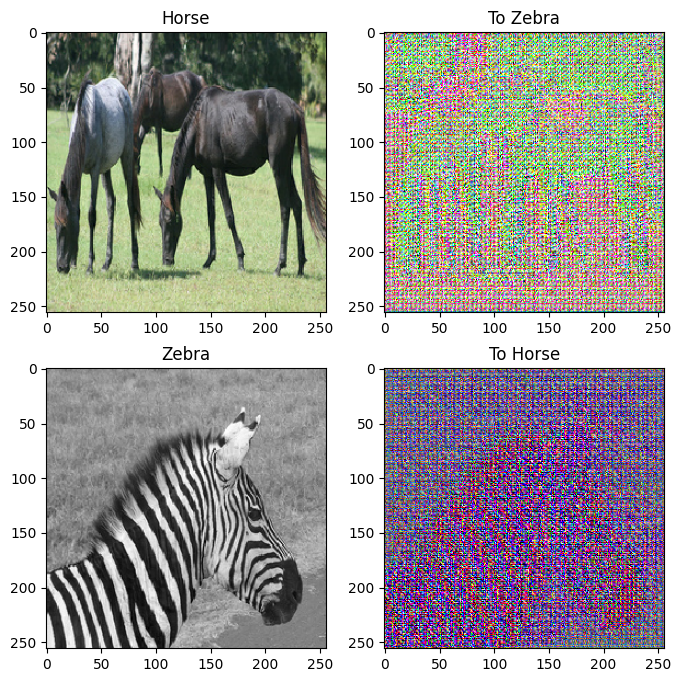

In [33]:
## Using the pretrained pix2pix generator models before training to see what they generate (garbage)

to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

### test for discriminator models

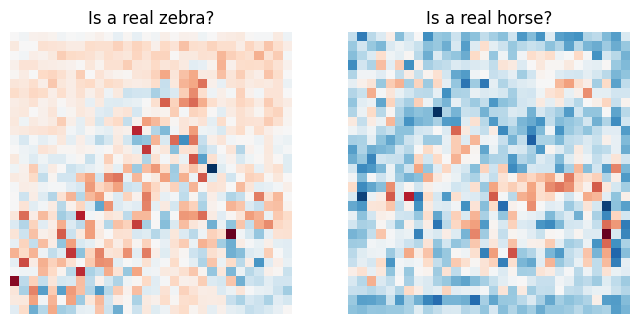

In [36]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.axis('off')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')
plt.axis('off')
plt.show()

# Loss functions
In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input x and the target y pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in pix2pix.

In CycleGAN, the **cycle consistency loss** ensures that the mapping between two domains is learned correctly, even when there is no paired data. Since CycleGAN uses unpaired data for image-to-image translation, there’s no direct way to verify if an image translated from one domain (say, domain X) to another domain (domain Y) is accurate.

Cycle consistency loss is introduced to address this. It ensures that if an image is translated from one domain (X) to another domain (Y) and then back to the original domain (X), the result should be the same as the original image. This loss is computed in two steps:

1. **Forward cycle consistency**: An image \( x \) from domain X is translated to domain Y using the generator \( G_X \to Y \), then translated back to domain X using \( G_Y \to X \). The loss ensures that \( G_Y \to X(G_X \to Y(x)) \approx x \).

2. **Backward cycle consistency**: Similarly, an image \( y \) from domain Y is translated to domain X using \( G_Y \to X \), then translated back to domain Y using \( G_X \to Y \). The loss ensures that \( G_X \to Y(G_Y \to X(y)) \approx y \).

This bidirectional consistency helps the model learn meaningful mappings between the two domains, ensuring that the transformations are reversible and plausible, even without paired data.

In [37]:
LAMBDA = 10

In [38]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [40]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [57]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence.

In cycle consistency loss,

* Image X is passed via generator G that yields generated image Y-hat

* Generated image Y-hat is passed via generator F that yields cycled image X-hat

* Mean absolute error is calculated between and X and X-hat

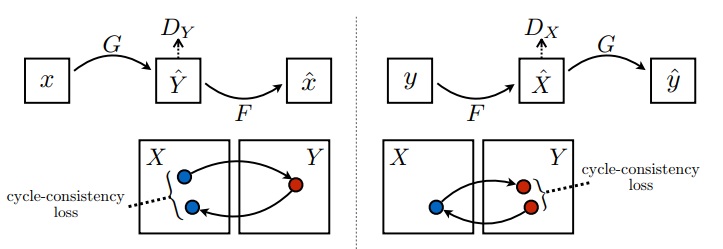

As we can see, in the left half the difference will be there (2 blue dots) which shows how the reconstructed image is not perfect, similarly for the right image we have differences between 2 red dots and they do not overlap, we calculate this loss and check how good the generators perform

In [44]:
# code for cycle loss
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

As shown above, generator G is responsible for translating image X to image Y. Identity loss says that, if you fed image Y to generator G, it should yield the real image Y or something close to image Y.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

In [43]:
# code for identity loss
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [45]:
#Initialize the optimizers for all the generators and the discriminators.

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints

In [47]:
# code to generate checkpoints
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# Training

In [54]:
EPOCHS = 15

In [49]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

the training loop has 4 steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [61]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

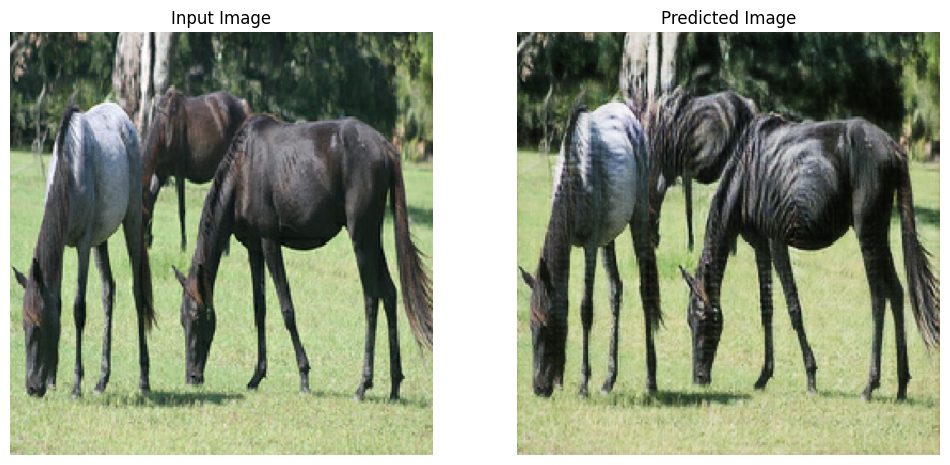

Saving checkpoint for epoch 15 at ./checkpoints/train/ckpt-3
Time taken for epoch 15 is 499.21 sec



In [64]:
from tqdm import tqdm
import time
import tensorflow as tf

# Training loop with tqdm progress bars
for epoch in range(EPOCHS):
    start = time.time()
    
    # Initialize the tqdm progress bar for the current epoch
    with tqdm(total=len(train_horses), desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch") as pbar:
        for n, (image_x, image_y) in enumerate(tf.data.Dataset.zip((train_horses, train_zebras))):
            # Call the training step
            train_step(image_x, image_y)
            
            # Update the tqdm progress bar
            pbar.update(1)
        
    clear_output(wait=True)
    
    # Generate images using a consistent test image (sample_horse) to visualize model progress
    generate_images(generator_g, sample_horse)

    # Save a checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    # Print the time taken for the epoch
    print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')


In [63]:
!pip install tqdm

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


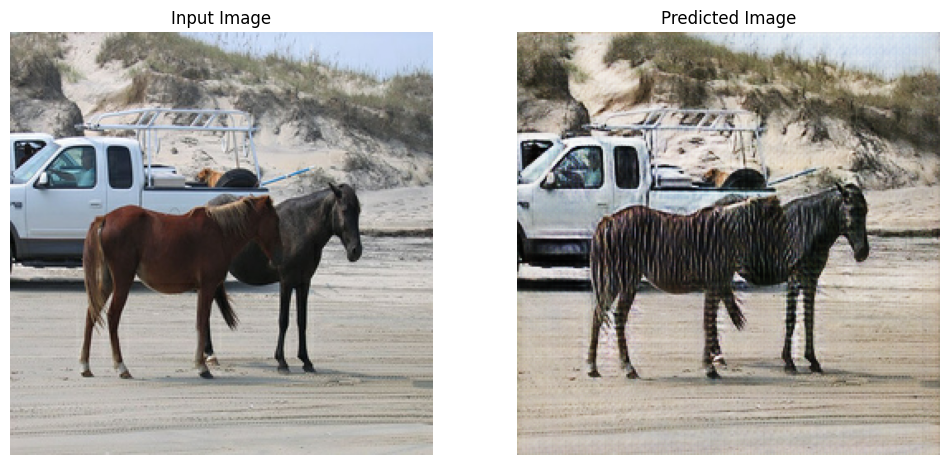

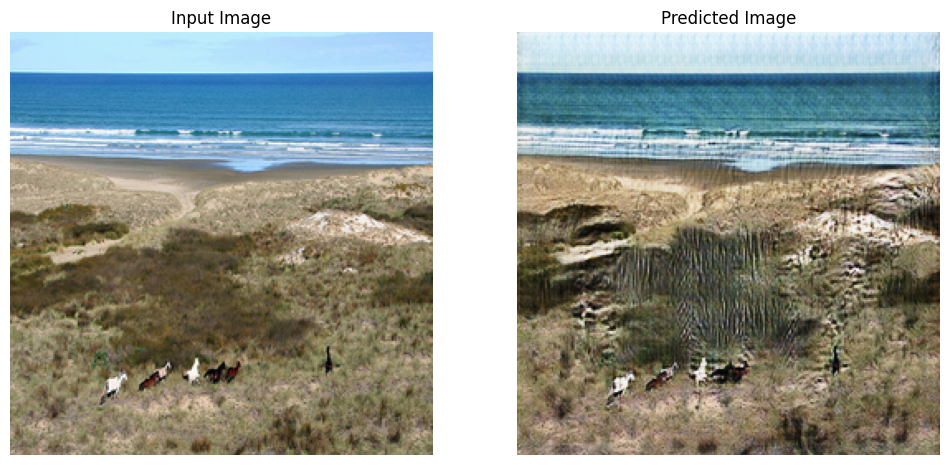

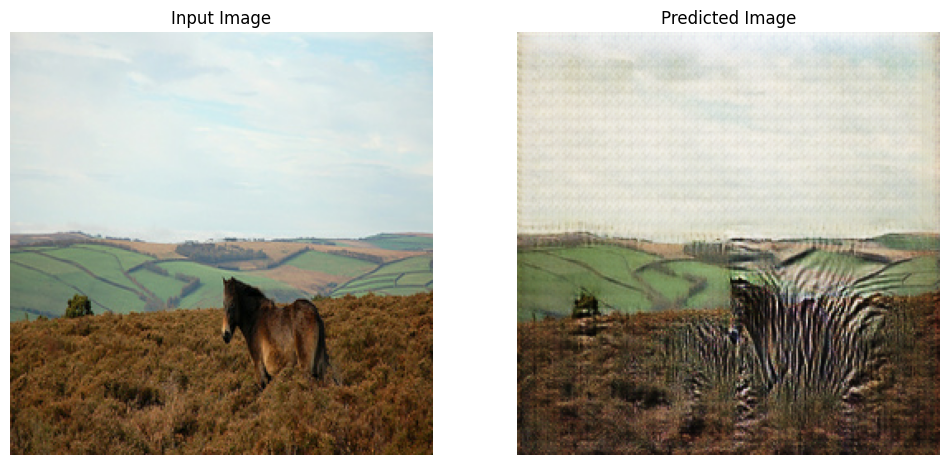

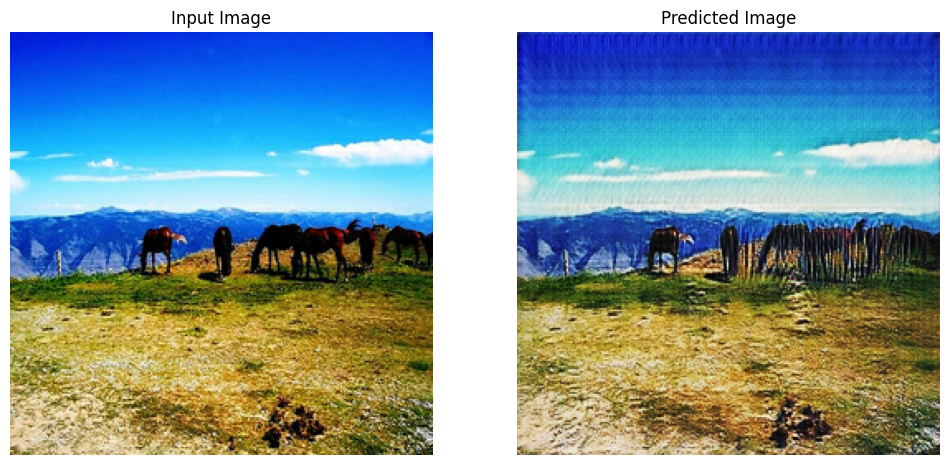

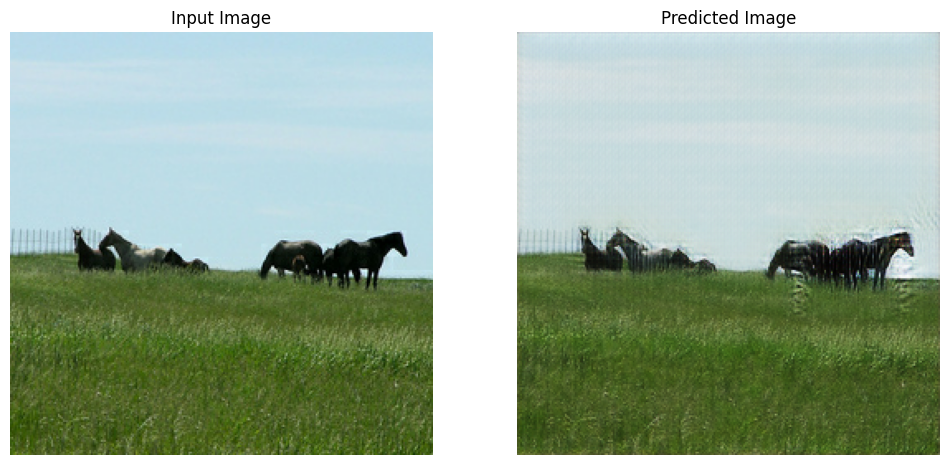

In [65]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)